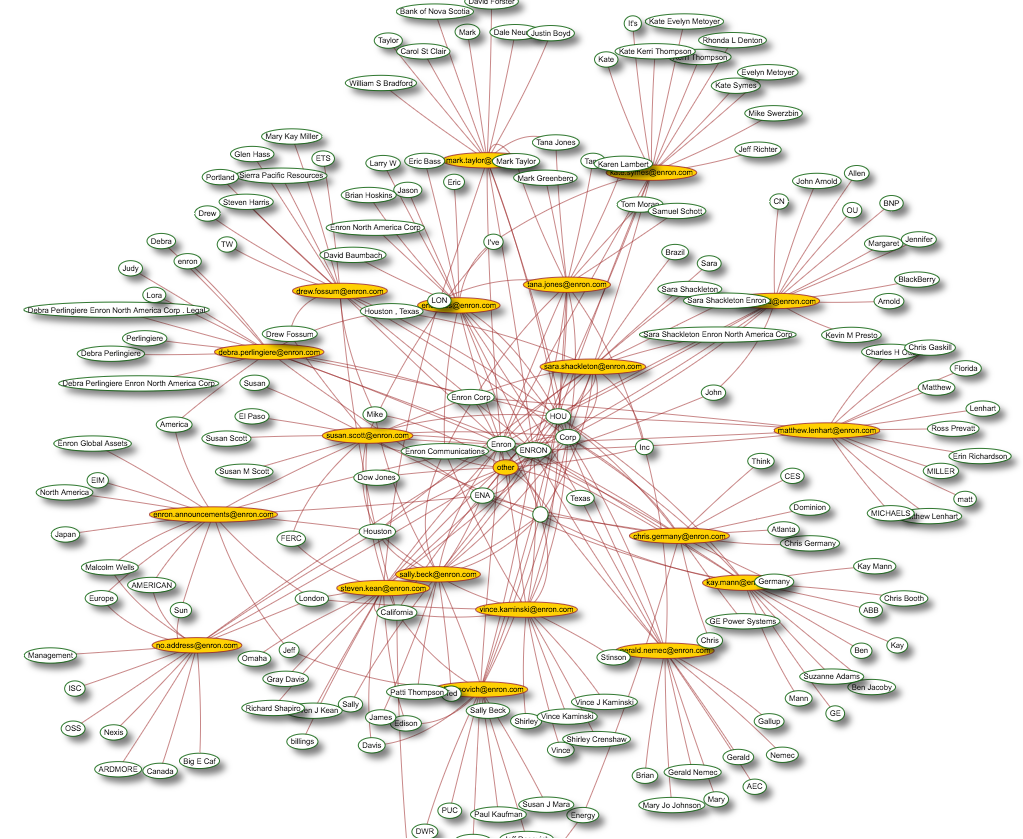

In [25]:
from IPython.display import Image
Image("Enron_Emails.png",width=400,height=350)

In [2]:
#we are importing email package for convenience
import os, sys, email,re
import numpy as np 
import pandas as pd
from palettable.tableau import Tableau_20
import json
# Plotting
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud
from os import listdir, chdir
# Network analysis
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from stop_words import get_stop_words

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
# To build the dictionary
from collections import defaultdict

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
all_emails=pd.read_csv("emails.csv")
emails_subset=all_emails.sample(frac=0.03,random_state=1)
emails_subset.to_csv("Enron_emails_small.csv")

In [3]:
emails_df=pd.read_csv('Enron_emails_small.csv')
emails_df=emails_df.iloc[:,1:]

print("successfully loaded {} rows and {} columns!".format (emails_df.shape[0], emails_df.shape[1]))
print(emails_df.head())

successfully loaded 15522 rows and 2 columns!
                         file  \
0  jones-t/all_documents/634.   
1  mann-k/all_documents/5690.   
2        dasovich-j/sent/423.   
3          kaminski-v/var/63.   
4     mann-k/_sent_mail/3208.   

                                             message  
0  Message-ID: <17820178.1075846925335.JavaMail.e...  
1  Message-ID: <29110382.1075845717882.JavaMail.e...  
2  Message-ID: <6812040.1075843194135.JavaMail.ev...  
3  Message-ID: <21547648.1075856642126.JavaMail.e...  
4  Message-ID: <12684200.1075846107179.JavaMail.e...  


In [6]:
#Take a closer look at email
emails_df.message[1]

'Message-ID: <29110382.1075845717882.JavaMail.evans@thyme>\nDate: Tue, 15 May 2001 11:03:00 -0700 (PDT)\nFrom: kay.mann@enron.com\nTo: sheila.tweed@enron.com\nSubject: Re: Override letter\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Kay Mann\nX-To: Sheila Tweed\nX-cc: \nX-bcc: \nX-Folder: \\Kay_Mann_June2001_1\\Notes Folders\\All documents\nX-Origin: MANN-K\nX-FileName: kmann.nsf\n\nAbsolutely.  \n\n\nFrom: Sheila Tweed@ECT on 05/15/2001 06:02 PM\nTo: Kay Mann/Corp/Enron@ENRON\ncc:  \n\nSubject: Re: Override letter  \n\nGood point!  Can Peter start to draft an override letter?\n\n\n\n\tKay Mann@ENRON\n\t05/15/2001 05:55 PM\n\t\t \n\t\t To: pthompson@akllp.com\n\t\t cc: Sheila Tweed/HOU/ECT@ECT, Roseann Engeldorf/Enron@EnronXGate, Scott \nDieball/ENRON_DEVELOPMENT@ENRON_DEVELOPMENt, John G \nRigby/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT\n\t\t Subject: Override letter\n\nAs a reminder to all of us, we will need a form override lette

In [7]:
#returns a message object structure from a string.
Messages=list(map(email.message_from_string,emails_df['message']))

In [8]:
emails_df.drop('message',axis=1,inplace=True)

In [7]:
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [9]:
keys=Messages[0].keys()

In [10]:
for key in keys:
    emails_df[key]=[doc[key] for doc in Messages]

In [8]:
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [11]:
def get_text_from_email(msg):
    parts=[]
    # each part is a either non-multipart, or another multipart message
    # that contains further parts... Message is organized like a tree
    for part in msg.walk():
        if part.get_content_type() =='text/plain':
            parts.append(part.get_payload())
    return ''.join(parts)

In [12]:
def split_email_address(line):
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs    

In [13]:
emails_df['content']=list(map(get_text_from_email,Messages))

In [14]:
emails_df['From']=emails_df['From'].map(split_email_address)

In [15]:
emails_df['To']=emails_df['To'].map(split_email_address)

In [16]:
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del Messages

<b> Who sends most emails? </b>

In [17]:
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [18]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

,N emails,Subject word count,Content word count
user,,,
kaminski-v,913,4.328587,254.765608
dasovich-j,830,5.404819,526.301205
kean-s,735,5.016327,481.293878
mann-k,676,4.207101,214.005917
jones-t,638,4.669279,187.956113


<b> Social network analyses of email senders and recipients </b>

In [20]:
sub_df = emails_df[['From', 'To', 'Date']].dropna()
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
6226,pete.davis@enron.com,pete.davis@enron.com,295
6601,vince.kaminski@enron.com,vkaminski@aol.com,131
5639,enron.announcements@enron.com,all.worldwide@enron.com,71
5640,enron.announcements@enron.com,all.houston@enron.com,55
5840,kay.mann@enron.com,suzanne.adams@enron.com,51
6609,vince.kaminski@enron.com,shirley.crenshaw@enron.com,38
7027,steven.kean@enron.com,maureen.mcvicker@enron.com,32
4194,evelyn.metoyer@enron.com,kate.symes@enron.com,29
4396,drew.fossum@enron.com,martha.benner@enron.com,29
5850,kay.mann@enron.com,nmann@erac.com,27


<b> What do the emails say? </b>

(-0.5, 799.5, 599.5, -0.5)

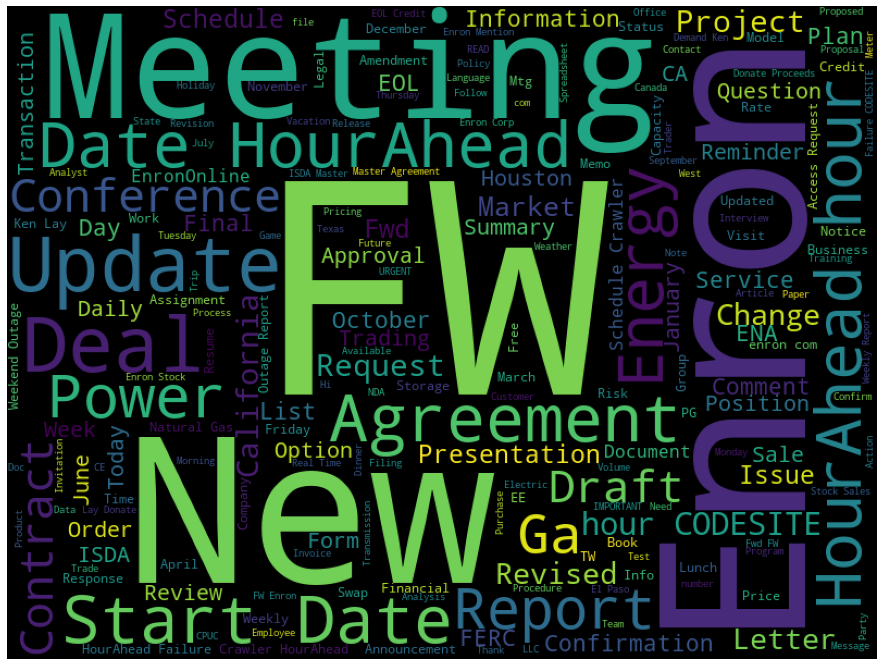

In [21]:

subjects = ' '.join(emails_df['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

In content:

(-0.5, 799.5, 599.5, -0.5)

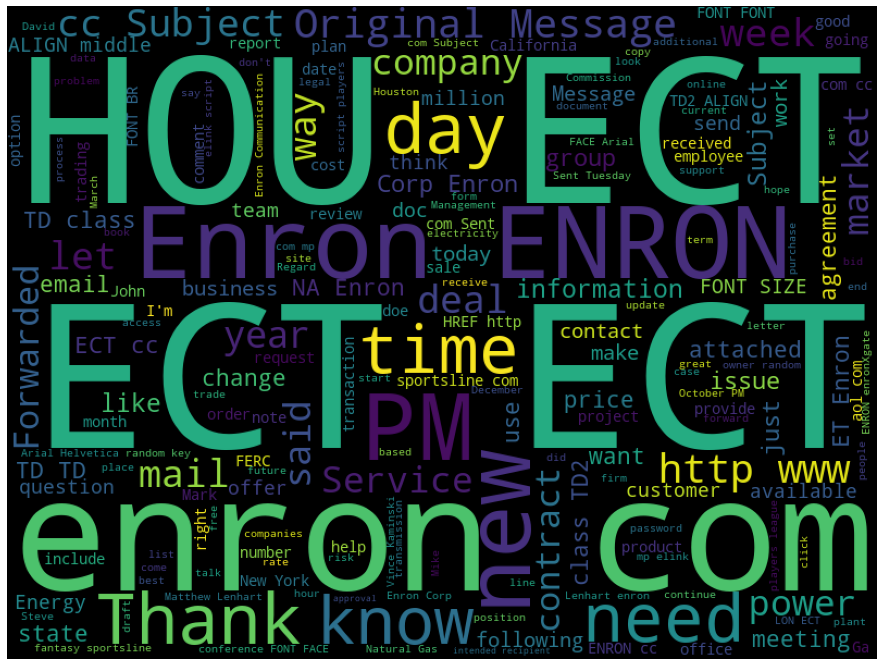

In [23]:
contents = ' '.join(emails_df.sample(1000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")